In [1]:
! pip install keras --upgrade
! pip install imblearn --upgrade
! pip install statsmodels
! pip install --upgrade sklearn

    100% |████████████████████████████████| 317kB 28.6MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 29.1MB/s ta 0:00:01
    100% |████████████████████████████████| 2.8MB 16.4MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 35.9MB/s ta 0:00:01
    100% |████████████████████████████████| 174kB 24.1MB/s ta 0:00:01
    100% |████████████████████████████████| 5.4MB 10.2MB/s ta 0:00:01
  Found existing installation: scikit-learn 0.18.2
    Uninstalling scikit-learn-0.18.2:
      Successfully uninstalled scikit-learn-0.18.2
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /home/gryduser/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn




Porto Seguro: balancing samples in mini-batches with Keras
==========================================================

This example compares two strategies to train a neural-network on the Porto
Seguro Kaggle data set [1]_. The data set is imbalanced and we show that
balancing each mini-batch allows to improve performance and reduce the training
time.

References
----------

In [1]:
%matplotlib inline
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import table

In [3]:


# Data loading

white = pd.read_csv("./data/winequality-white.csv", sep=";")
red = pd.read_csv("./data/winequality-red.csv", sep=';')

# print outliers
print(white.isnull().sum())
print(red.isnull().sum())

white.rename(columns={"fixed acidity":'fixed_acidity', "volatile acidity":"vol_acidity", 
                      'citric acid':"citric_acid", "free sulfur dioxide":"free_sul_dioxide", 
                      "total sulfur dioxide":"total_SD", "residual sugar": "resid_sugar"}, inplace=True)
red.rename(columns={"fixed acidity":'fixed_acidity', "volatile acidity":"vol_acidity", 
                    'citric acid':"citric_acid", "free sulfur dioxide":"free_sul_dioxide", 
                    "total sulfur dioxide":"total_SD", "residual sugar": "resid_sugar"}, inplace=True)
cols = white.columns.tolist()

whiteH = white[white["quality"]>=7]
redH = red[red["quality"]>=7]

whiteM = white[(white["quality"]>=5) & (white["quality"]<=6)]
whiteL = white[white['quality']<=4]

redM = red[(red["quality"]>=5) & (red["quality"]<=6)]
redL = red[red['quality']<=4]


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [4]:
whiteH.loc[:,'group'] = 'H'
redH.loc[:,'group'] = 'H'
whiteM.loc[:,'group'] = 'M'
whiteL.loc[:,'group'] = 'L'
redM.loc[:,'group'] = 'M'
redL.loc[:,'group'] = 'L'
redn = redM.append(redL)
redn = redn.append(redH)
whiten = whiteM.append(whiteL)
whiten = whiten.append(whiteH)


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor,AdaBoostClassifier
from sklearn.metrics import auc, r2_score,log_loss, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer, label_binarize, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SVMSMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

import itertools
import warnings
warnings.filterwarnings("ignore")

def one_hot(mat, num_classes=3):
    """
    Arguments
    ---------
    # mat - matrix 
        shape= , including vector integer which have shape=[batch,] # label present this really an (m x 1) vec  
    # num_classes - num of classes
        shape=[batch_size, ] vector containing scalar true label for row 

    final_size: matrix
        containing true vectors in place of the single scalar

    Returns
    -------
    list:
    A list which is contains the operations to be preformed in model run.
    """
    
    squeezed_vector = np.squeeze(np.int8(mat))
    one_hot = np.zeros((squeezed_vector.size, num_classes))
    one_hot[np.arange(squeezed_vector.size), squeezed_vector] = 1

    return one_hot

def plc(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = -1, train_sizes = np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X, y,
                                                            cv = cv,
                                                            n_jobs = n_jobs,
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return

def gridsearchCV(x,y, steps, param_grid, scoring='balanced_accuracy', split=0.3, printFeatureImportance=False, cv_folds=5, plt_mat=False):
    
    le = LabelEncoder()    
    y = le.fit_transform(y)
    X_trainr, X_testr, y_trainr, y_testr = train_test_split(x, y, test_size = 0.3, random_state=2)
    pipe = Pipeline(steps)
    uniq = np.unique(y_testr).tolist()
    uniq = [str(x) for x in uniq]
    #Perform cross-validation:
    # Instantiate the GridSearchCV object: logreg_cv
    clfr_cv = GridSearchCV(pipe, param_grid, scoring=scoring, cv=cv_folds)

    # Fit it to the data
    clfr_cv.fit(X_trainr, y_trainr)
    y_p = clfr_cv.predict(X_testr)

    # Print the tuned parameters and score
    print("Model: {}".format(type(clfr_cv.estimator.steps[1][1])))
    print("Tuned Parameters: {}".format(clfr_cv.best_params_)) 
    print("Tuned balanced accuracy {}".format(clfr_cv.best_score_))
    print(classification_report(y_testr, y_p, target_names=uniq))

    if plt_mat:
        fig, ax = plt.subplots()
        cm_ = confusion_matrix(y_testr, y_p)
        plot_confusion_matrix(cm_, classes=uniq, ax=ax,
                              title='Class Matrix')
    b_est = clfr_cv.best_estimator_
    est = clfr_cv.estimator.steps
    list_classes = clfr_cv.classes_
    b_score = clfr_cv.best_score_
    return b_est, list_classes, b_score    
        
    
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    #tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    #plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


def PCAplot(Xw, labels=None, ax=None, title=""):
    scaler = StandardScaler()
    scaler.fit(Xw)
    X=scaler.transform(Xw)
    pca = PCA()
    x_new = pca.fit_transform(X)
    score = x_new
    coeff = np.transpose(pca.components_)
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    #scalex = 1.0/(xs.max() - xs.min())
    #scaley = 1.0/(ys.max() - ys.min())
    #plt.scatter(xs ,ys, c = Yw)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.3, linewidth=7)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center', fontsize=16)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', fontsize=16)

    title = title + "Principle Component Analysis"
    plt.xlim(-0.8,0.8)
    plt.ylim(-0.8,0.8)
    plt.title(title)
    plt.xlabel("Component{}".format(1))
    plt.ylabel("Component{}".format(2))
    plt.grid()

# Machine Learning for Classification of wine quality

## Model Selection

Here we present the classification of wine using a grouping method by grouping the wine classes into high, mid, and low quality. The decision was made to perform this grouping due to the low count at the low and high ends of the dataset as well as the subjective collection method of the dataset. This data not only has features with high collinearity - it also has high dimensionality which means any linear model will not be sufficient enough make correct predictions time and time again. This means the models which should work the best are non linear classifiers. We will grid search over a set of parameters to find the optimal settings for each model as well as check to see if normalizing or PCA is the transformation for the data before feeding it into each model.


We will Grid Search for best model and parameters for each class of wine. The main goal is to find the best model to capture each class and use a voting classifier to do its best job of getting every predict correct. Without a deep dive into topological data analysis we will do a greedy search to see which algorithms would work best on this problem. It is very clear we have labelled data which makes our search point toward supervised learning algorithms. The output from our model is a class which makes this a classification problem. Yet we could also think of this problem as a set of input groups by grouping the classes into low, mid, and high which turns into a clustering problem.


## White wine quality classification

Before building classification models the first thing we must do is evaluate the collinearity between variables. By doing this analysis first we can improve any model by droping features with high colinearity among each other. 

### Feature engineering
`Fixed acidity` is measured as `total acidity` minus `volatile acidity`. Generally, `pH` is a quantitative assessment of `fixed acidity`. This is important in feature engineering because we do not want redundant features nor do we want to keep features which have less sensitive measurements. The concept of pH is abstract, and knowing the details is not as important in understanding the relationship between acidity and balance in the wine. `pH` is a quantitative measurement of fixed acidity so having both features is redundant and should be avoided. So `Fixed acidity` will be removed as a feature. 

From the plot below we can see the colinearity much more clearly than using regression based methods. From the PC analysis we can see which features are correlated with each other. We can see that `chlorides`, `density`,  and `sulphates` are highly correlated. The same is for `total_SD`, `citric_acid`, `free_sul_dioxide`. This leaves us to pick the best from the groups and feed them into a model. The vector represents the coefficient of the feature so it is best to remove the weakest of the correlated features. `total_SD`, `density`,  and `sulphates`. We choose to leave `free_sul_dioxide` because it is far enough from `citric_acid` that we can investigate later if it is harming our model or not. We can see that the classical VIF score of feature selection is not as useful as PCA in feature engineering in machine learning.

In [6]:
# label encoding of groups
# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()

# force pandas to behave like a dataframe by passing a list of columns for the one hot
Yw = whiten.group.values #
# Yw = le.fit_transform(Yw)
Xw = whiten.drop(['group', 'quality'], axis = 1)


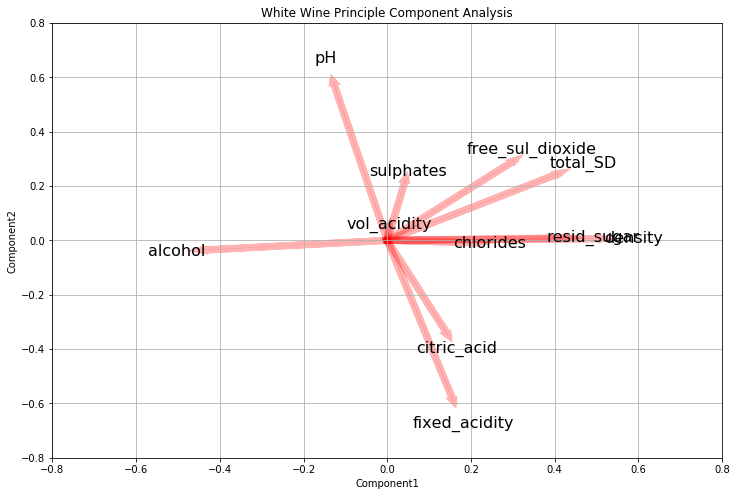

In [7]:
#Call the function. Use only the 2 PCs.
PCAplot(Xw,labels=Xw.columns.tolist(), ax=plt.subplots(figsize=(12,8)), title="White Wine ")
plt.savefig('W_pca1.png', dpi=300)

In [8]:
# remove features and perform PCA again
__Xw = Xw.copy()
__Xw = __Xw.drop(['resid_sugar', 'chlorides', 'citric_acid', 'alcohol', 'total_SD'], axis = 1)

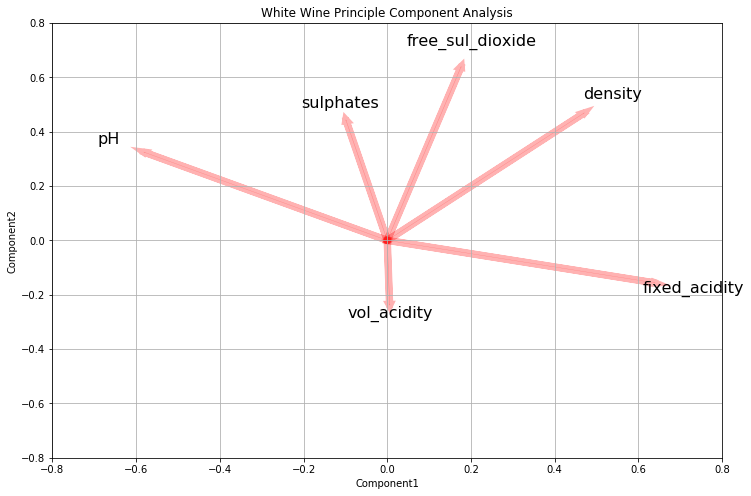

In [9]:
PCAplot(__Xw,labels=__Xw.columns.tolist(), ax=plt.subplots(figsize=(12,8)), title="White Wine ")
plt.savefig('W_pca2.png', dpi=300)

In [10]:
# Using original labels
# sampling for logistic regression
X_rsW_smt, y_rsW_smt = SMOTE(k_neighbors=4,n_jobs=-1).fit_resample(__Xw, whiten.quality.values)
X_rsW_ada, y_rsW_ada = ADASYN(n_neighbors=4,n_jobs=-1).fit_resample(__Xw, whiten.quality.values)

# Grouping
# sampling for logistic regression
gX_rsW_smt, gy_rsW_smt = SMOTE(k_neighbors=4,n_jobs=-1).fit_resample(__Xw, Yw)
gX_rsW_ada, gy_rsW_ada = ADASYN(n_neighbors=4,n_jobs=-1).fit_resample(__Xw, Yw)
# sampling for support vector machines
gX_rsW_svm, gy_rsW_svm = SVMSMOTE(k_neighbors=4,n_jobs=-1,m_neighbors=4).fit_resample(__Xw, Yw)

In [11]:
# parameters
n_leaf = np.arange(1,6)
depth = np.arange(3,7)
c_space = np.logspace(-1, 1, 4)
n_features_to_test = np.arange(3,7)
k_space = np.arange(1,7)
kernel = ['rbf','poly'] # for linear SVC
degree = [3,4,5]

# start dataframe 
w_results = pd.DataFrame()

In [12]:
c_svm = [15,1]
g_space = [1,10]


# Classify using orginal labels


##### Logistic Regression

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.46415888336127786, 'reg__random_state': 0}
Tuned balanced accuracy 0.19332816016987844
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.02      0.05        42
           2       0.49      0.35      0.41       425
           3       0.50      0.82      0.62       683
           4       0.59      0.09      0.16       266
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00         1

   micro avg       0.50      0.50      0.50      1470
   macro avg       0.30      0.18      0.18      1470
weighted avg       0.49      0.50      0.43      1470

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 2.1544346900318834, 'reg__random_state': 0}
Tuned balanced accuracy 0.16645260392516503
              precision    recall  f

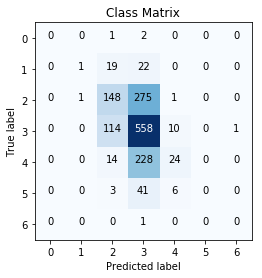

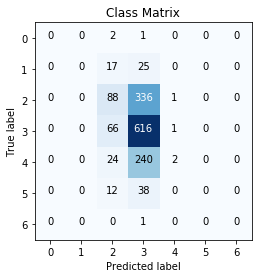

In [13]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'reg__C': c_space,
              'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(__Xw, whiten.quality.values,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'No',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
grid = {'PCA__n_components': n_features_to_test,
        'reg__C': c_space,
        'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(__Xw, whiten.quality.values,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'No',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### Logistic Regression imbalanced dataset

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.46415888336127786, 'reg__random_state': 0}
Tuned balanced accuracy 0.4267710983858957
              precision    recall  f1-score   support

           0       0.39      0.41      0.40       632
           1       0.48      0.55      0.51       664
           2       0.38      0.41      0.40       652
           3       0.27      0.15      0.19       705
           4       0.32      0.31      0.31       633
           5       0.37      0.37      0.37       674
           6       0.71      0.89      0.79       656

   micro avg       0.44      0.44      0.44      4616
   macro avg       0.42      0.44      0.42      4616
weighted avg       0.42      0.44      0.42      4616

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.10000000000000001, 'reg__random_state': 0}
Tuned balanced accuracy 0.38078696271954643
              precision    recall  f

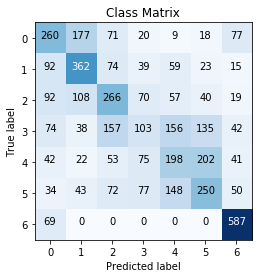

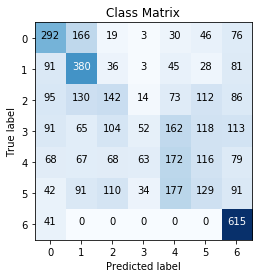

In [14]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'reg__C': c_space,
              'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(X_rsW_smt, y_rsW_smt,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original',
                                'Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
grid = {'PCA__n_components': n_features_to_test,
        'reg__C': c_space,
        'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(X_rsW_smt, y_rsW_smt,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.10000000000000001, 'reg__random_state': 0}
Tuned balanced accuracy 0.4179315791532754
              precision    recall  f1-score   support

           0       0.35      0.36      0.35       652
           1       0.48      0.53      0.50       637
           2       0.41      0.38      0.39       625
           3       0.28      0.19      0.22       707
           4       0.33      0.34      0.34       660
           5       0.37      0.36      0.36       655
           6       0.68      0.88      0.76       660

   micro avg       0.43      0.43      0.43      4596
   macro avg       0.41      0.43      0.42      4596
weighted avg       0.41      0.43      0.42      4596

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.10000000000000001, 'reg__random_state': 0}
Tuned balanced accuracy 0.3761983634880319
              precision    recall  f1

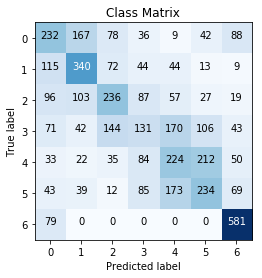

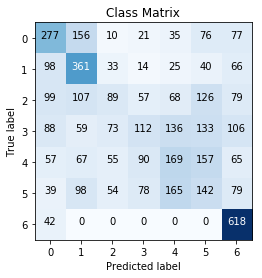

In [15]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'reg__C': c_space,
              'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(X_rsW_ada, y_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
grid = {'PCA__n_components': n_features_to_test,
        'reg__C': c_space,
        'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(X_rsW_ada, y_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### KNeighbors Classifier
Here we can see that K Nearest Neighbors pipeline with standard scaler is the best at classifying the middle quality group of wines yet mediocore at the other two groups.

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform'}
Tuned balanced accuracy 0.38018433670151974
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.39      0.29      0.33        42
           2       0.57      0.61      0.59       425
           3       0.66      0.64      0.65       683
           4       0.55      0.53      0.54       266
           5       0.41      0.36      0.38        50
           6       0.00      0.00      0.00         1

   micro avg       0.59      0.59      0.59      1470
   macro avg       0.37      0.35      0.36      1470
weighted avg       0.59      0.59      0.59      1470

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform', 'PCA__n_components': 6}
Tuned balanced accuracy 0.3178031284913525
              precis

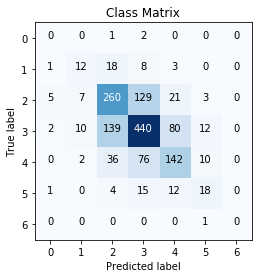

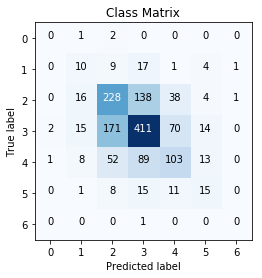

In [16]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
param_grid = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(__Xw, whiten.quality.values,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
param_grid = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(__Xw, whiten.quality.values,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### KNeighbors: imblearn

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform'}
Tuned balanced accuracy 0.8267178944076442
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       632
           1       0.84      0.94      0.89       664
           2       0.73      0.67      0.70       652
           3       0.65      0.51      0.57       705
           4       0.72      0.76      0.74       633
           5       0.87      0.94      0.90       674
           6       0.99      1.00      0.99       656

   micro avg       0.83      0.83      0.83      4616
   macro avg       0.82      0.83      0.83      4616
weighted avg       0.82      0.83      0.82      4616

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform', 'PCA__n_components': 5}
Tuned balanced accuracy 0.7960339771333881
              precisi

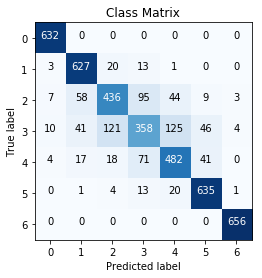

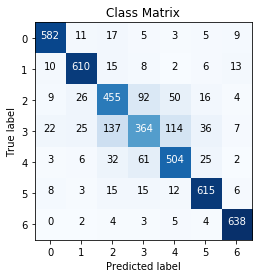

In [17]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
param_grid = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(X_rsW_smt, y_rsW_smt,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
param_grid = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(X_rsW_smt, y_rsW_smt,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)


Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform'}
Tuned balanced accuracy 0.8240401929590108
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       652
           1       0.86      0.94      0.90       637
           2       0.72      0.68      0.70       625
           3       0.66      0.51      0.57       707
           4       0.72      0.75      0.73       660
           5       0.83      0.93      0.88       655
           6       0.99      1.00      1.00       660

   micro avg       0.83      0.83      0.83      4596
   macro avg       0.82      0.83      0.82      4596
weighted avg       0.82      0.83      0.82      4596

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform', 'PCA__n_components': 6}
Tuned balanced accuracy 0.7827813592667616
              precisi

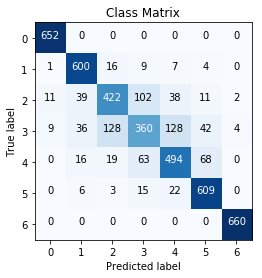

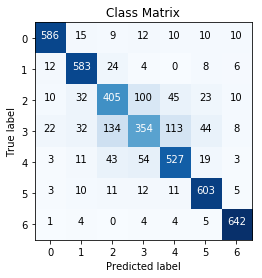

In [18]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
param_grid = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(X_rsW_ada, y_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
param_grid = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(X_rsW_ada, y_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)


##### Random Forests
As expected random forest algorithms do not perform well with data which is grouped.


Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__min_samples_leaf': 5, 'forest__n_estimators': 100, 'forest__random_state': 2}
Tuned balanced accuracy 0.22403045635341926
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        42
           2       0.52      0.50      0.51       425
           3       0.53      0.75      0.62       683
           4       0.59      0.20      0.30       266
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00         1

   micro avg       0.53      0.53      0.53      1470
   macro avg       0.23      0.21      0.20      1470
weighted avg       0.50      0.53      0.49      1470

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 6, 'forest__max_depth': 6, 'forest__min_samples_leaf': 3, 'fo

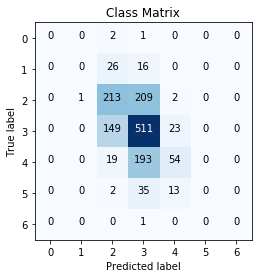

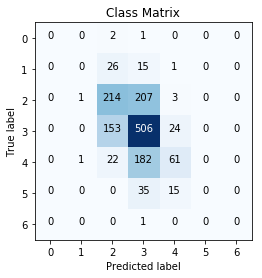

In [19]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(__Xw, whiten.quality.values,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(__Xw, whiten.quality.values,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### Random Forest: imblearn

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__min_samples_leaf': 3, 'forest__n_estimators': 100, 'forest__random_state': 2}
Tuned balanced accuracy 0.6135362991922915
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       632
           1       0.67      0.64      0.66       664
           2       0.42      0.57      0.48       652
           3       0.38      0.21      0.27       705
           4       0.46      0.45      0.46       633
           5       0.64      0.71      0.68       674
           6       0.90      0.99      0.94       656

   micro avg       0.62      0.62      0.62      4616
   macro avg       0.61      0.63      0.61      4616
weighted avg       0.61      0.62      0.61      4616

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 6, 'forest__max_depth': 6, 'forest__min_samples_leaf': 2, 'for

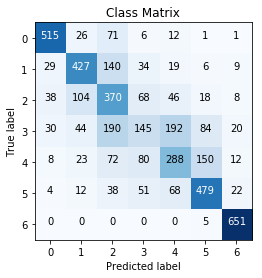

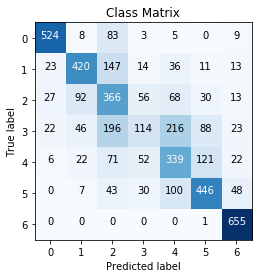

In [20]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(X_rsW_smt, y_rsW_smt,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(X_rsW_smt, y_rsW_smt,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__min_samples_leaf': 1, 'forest__n_estimators': 100, 'forest__random_state': 2}
Tuned balanced accuracy 0.5941713473243313
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       652
           1       0.64      0.65      0.65       637
           2       0.43      0.50      0.46       625
           3       0.37      0.23      0.29       707
           4       0.45      0.47      0.46       660
           5       0.60      0.64      0.62       655
           6       0.86      0.99      0.92       660

   micro avg       0.61      0.61      0.61      4596
   macro avg       0.60      0.61      0.60      4596
weighted avg       0.59      0.61      0.60      4596

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 6, 'forest__max_depth': 6, 'forest__min_samples_leaf': 1, 'for

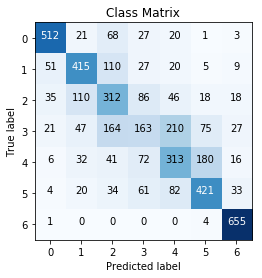

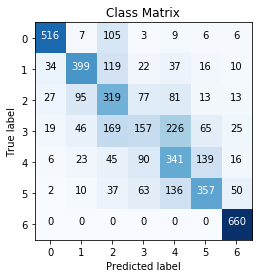

In [21]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(X_rsW_ada, y_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(X_rsW_ada, y_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### Support Vector Machines

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 15, 'SVM__gamma': 1}
Tuned balanced accuracy 0.35661275152722816
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.29      0.24      0.26        42
           2       0.57      0.64      0.60       425
           3       0.65      0.61      0.63       683
           4       0.54      0.54      0.54       266
           5       0.37      0.36      0.36        50
           6       0.00      0.00      0.00         1

   micro avg       0.58      0.58      0.58      1470
   macro avg       0.35      0.34      0.34      1470
weighted avg       0.58      0.58      0.58      1470



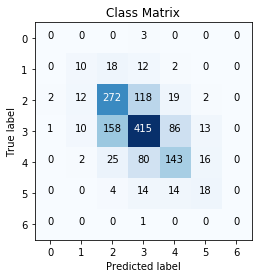

In [22]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo', kernel='rbf',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
param_grid = {'SVM__C': c_svm,
              'SVM__gamma' : g_space}
est, cls, scr = gridsearchCV(__Xw, whiten.quality.values,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 5, 'SVM__C': 15, 'SVM__gamma': 10}
Tuned balanced accuracy 0.3029648603895678
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.20      0.19      0.20        42
           2       0.49      0.55      0.52       425
           3       0.60      0.59      0.60       683
           4       0.45      0.39      0.42       266
           5       0.33      0.30      0.32        50
           6       0.00      0.00      0.00         1

   micro avg       0.52      0.52      0.52      1470
   macro avg       0.30      0.29      0.29      1470
weighted avg       0.52      0.52      0.52      1470



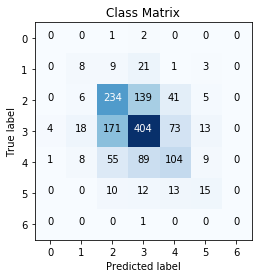

In [23]:
# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo',kernel='rbf',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
param_grid = {'PCA__n_components': [3,4,5,6],
              'SVM__C': c_svm,
              'SVM__gamma' : g_space}
est, cls, scr = gridsearchCV(__Xw, whiten.quality.values,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### Linear Support Vector Machines: imblearn

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 15, 'SVM__gamma': 1}
Tuned balanced accuracy 0.8159437304750999
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       632
           1       0.86      0.95      0.91       664
           2       0.67      0.71      0.69       652
           3       0.63      0.48      0.55       705
           4       0.72      0.72      0.72       633
           5       0.88      0.94      0.91       674
           6       0.99      1.00      1.00       656

   micro avg       0.82      0.82      0.82      4616
   macro avg       0.82      0.83      0.82      4616
weighted avg       0.82      0.82      0.82      4616

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 5, 'SVM__C': 15, 'SVM__gamma': 10}
Tuned balanced accuracy 0.7898538100752861
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       632
 

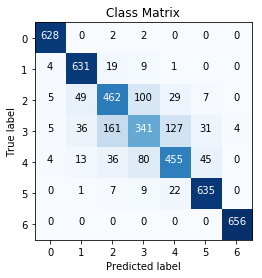

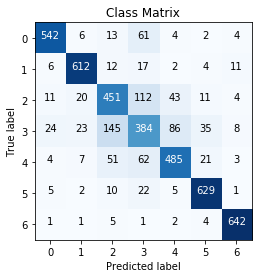

In [24]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo', kernel='rbf',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
param_grid = {'SVM__C': c_svm,
              'SVM__gamma' : g_space}
est, cls, scr = gridsearchCV(X_rsW_smt, y_rsW_smt, steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo',kernel='rbf',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
param_grid = {'PCA__n_components': [4,5],
              'SVM__C': c_svm,
              'SVM__gamma' : g_space}
est, cls, scr = gridsearchCV(X_rsW_smt, y_rsW_smt, steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 15, 'SVM__gamma': 1}
Tuned balanced accuracy 0.8090453419458427
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       652
           1       0.87      0.94      0.90       637
           2       0.67      0.69      0.68       625
           3       0.62      0.52      0.56       707
           4       0.71      0.72      0.72       660
           5       0.87      0.91      0.89       655
           6       1.00      1.00      1.00       660

   micro avg       0.82      0.82      0.82      4596
   macro avg       0.82      0.82      0.82      4596
weighted avg       0.81      0.82      0.82      4596

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 6, 'SVM__C': 15, 'SVM__gamma': 10}
Tuned balanced accuracy 0.7782642263152113
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       652
 

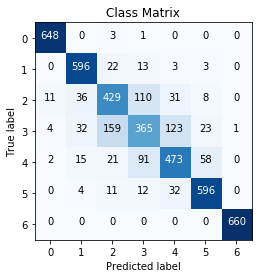

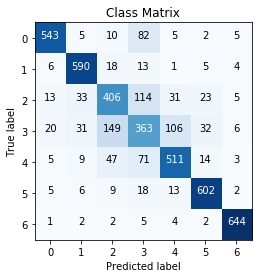

In [25]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo', kernel='rbf',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
param_grid = {'SVM__C': c_svm,
              'SVM__gamma' : g_space}
est, cls, scr = gridsearchCV(X_rsW_ada, y_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo',kernel='rbf',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
param_grid = {'PCA__n_components': [3,4,5,6],
              'SVM__C': c_svm,
              'SVM__gamma' : g_space}
est, cls, scr = gridsearchCV(X_rsW_ada, y_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Classify using grouped labels

### Logistic Regression

Using the analysis of colinearity between features to attempt in improving the model was not useful and did not improve logistic regression. From the results below we can see that it did not improve classification for any of the wine types. Logistic regression appears to only be good at classifying one type of wine. 


Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.46415888336127786, 'reg__random_state': 0}
Tuned balanced accuracy 0.36786905195775244
              precision    recall  f1-score   support

           0       0.70      0.10      0.18       317
           1       0.00      0.00      0.00        45
           2       0.77      0.99      0.86      1108

   micro avg       0.76      0.76      0.76      1470
   macro avg       0.49      0.36      0.35      1470
weighted avg       0.73      0.76      0.69      1470

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'PCA__n_components': 5, 'reg__C': 2.1544346900318834, 'reg__random_state': 0}
Tuned balanced accuracy 0.34515580099775783
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.00      0.00      0.00        45
           2       0.75      1.00      0.86      1108

   micro a

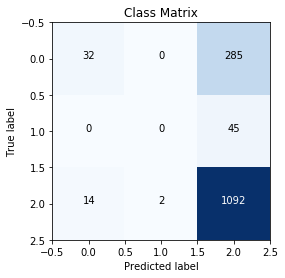

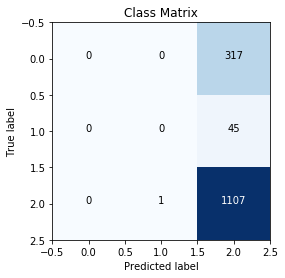

In [26]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
# Setup the hyperparameter grid
grid = {'reg__C': c_space,
        'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(__Xw, Yw, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
# Create the pipeline: pipeline
grid = {'PCA__n_components': n_features_to_test,
        'reg__C': c_space,
        'reg__random_state': [0,3,4,7]}

est, cls, scr = gridsearchCV(__Xw, Yw, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.10000000000000001, 'reg__random_state': 0}
Tuned balanced accuracy 0.6142417320645457
              precision    recall  f1-score   support

           0       0.60      0.73      0.66      1089
           1       0.69      0.67      0.68      1128
           2       0.53      0.44      0.48      1118

   micro avg       0.61      0.61      0.61      3335
   macro avg       0.61      0.61      0.61      3335
weighted avg       0.61      0.61      0.61      3335

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'PCA__n_components': 6, 'reg__C': 0.10000000000000001, 'reg__random_state': 0}
Tuned balanced accuracy 0.5253468835442261
              precision    recall  f1-score   support

           0       0.48      0.56      0.52      1089
           1       0.63      0.69      0.65      1128
           2       0.47      0.34      0.40      1118

   micro av

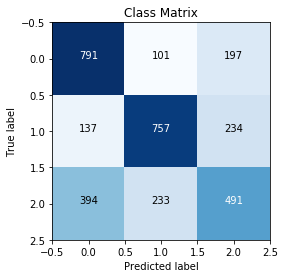

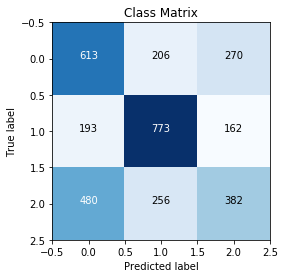

In [27]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
# Setup the hyperparameter grid
grid = {'reg__C': c_space,
        'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(gX_rsW_ada, gy_rsW_ada, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
# Create the pipeline: pipeline
grid = {'PCA__n_components': n_features_to_test,
        'reg__C': c_space,
        'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(gX_rsW_ada, gy_rsW_ada, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 2.1544346900318834, 'reg__random_state': 0}
Tuned balanced accuracy 0.5910011933361059
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      1078
           1       0.67      0.66      0.66      1103
           2       0.52      0.43      0.47      1109

   micro avg       0.59      0.59      0.59      3290
   macro avg       0.59      0.59      0.59      3290
weighted avg       0.59      0.59      0.58      3290

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'PCA__n_components': 4, 'reg__C': 0.10000000000000001, 'reg__random_state': 0}
Tuned balanced accuracy 0.5183042297965528
              precision    recall  f1-score   support

           0       0.48      0.55      0.51      1078
           1       0.62      0.70      0.66      1103
           2       0.46      0.34      0.39      1109

   micro avg

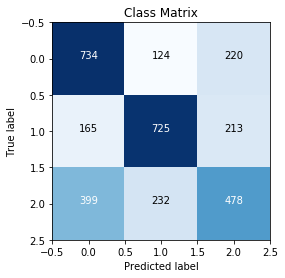

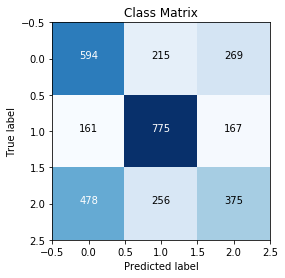

In [28]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
# Setup the hyperparameter grid
grid = {'reg__C': c_space,
        'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(gX_rsW_smt, gy_rsW_smt, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
# Create the pipeline: pipeline
grid = {'PCA__n_components': n_features_to_test,
        'reg__C': c_space,
        'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(gX_rsW_smt, gy_rsW_smt, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

### Nearest Neighbors 
Here we can see that K Nearest Neighbors pipeline with standard scaler is the best at classifying the middle quality group of wines yet mediocore at the other two groups.

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 3, 'K__weights': 'distance'}
Tuned balanced accuracy 0.5691977539213918
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       317
           1       0.35      0.24      0.29        45
           2       0.86      0.89      0.87      1108

   micro avg       0.80      0.80      0.80      1470
   macro avg       0.62      0.57      0.59      1470
weighted avg       0.79      0.80      0.80      1470

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 3, 'K__weights': 'distance', 'PCA__n_components': 4}
Tuned balanced accuracy 0.5037237252818517
              precision    recall  f1-score   support

           0       0.55      0.41      0.47       317
           1       0.30      0.24      0.27        45
           2       0.82      0.88      0.85      1108

   micro avg     

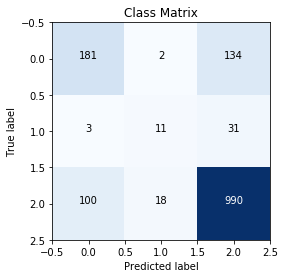

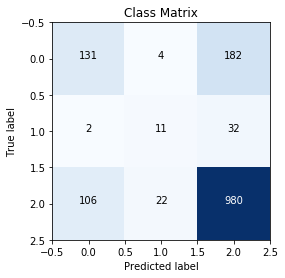

In [29]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': [3,4,5,6,7,8,9,10,11,15]}
est, cls, scr = gridsearchCV(__Xw, Yw, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': [3,4,5,6,7,8,9,10,11,15]}
est, cls, scr = gridsearchCV(__Xw, Yw, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### KNeighbors: imblearn

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 4, 'K__weights': 'distance'}
Tuned balanced accuracy 0.8340246473460747
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1078
           1       0.89      0.98      0.93      1103
           2       0.87      0.72      0.79      1109

   micro avg       0.86      0.86      0.86      3290
   macro avg       0.86      0.86      0.86      3290
weighted avg       0.86      0.86      0.86      3290

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 3, 'K__weights': 'distance', 'PCA__n_components': 5}
Tuned balanced accuracy 0.8264672726774172
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1078
           1       0.92      0.97      0.94      1103
           2       0.86      0.73      0.79      1109

   micro avg     

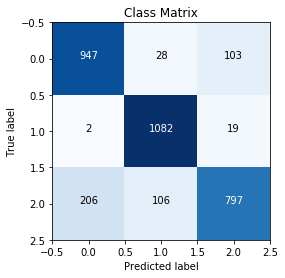

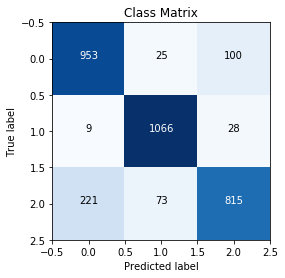

In [30]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': [3,4,5,6,7,8,9,10,11,15]}
est, cls, scr = gridsearchCV(gX_rsW_smt, gy_rsW_smt, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': [3,4,5,6,7,8,9,10,11,15]}
est, cls, scr = gridsearchCV(gX_rsW_smt, gy_rsW_smt, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 4, 'K__weights': 'distance'}
Tuned balanced accuracy 0.8365864504088365
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1089
           1       0.88      0.98      0.93      1128
           2       0.89      0.70      0.79      1118

   micro avg       0.86      0.86      0.86      3335
   macro avg       0.86      0.86      0.85      3335
weighted avg       0.86      0.86      0.85      3335

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 4, 'K__weights': 'distance', 'PCA__n_components': 5}
Tuned balanced accuracy 0.8278936653991176
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1089
           1       0.91      0.97      0.94      1128
           2       0.89      0.72      0.80      1118

   micro avg     

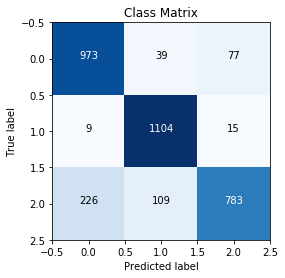

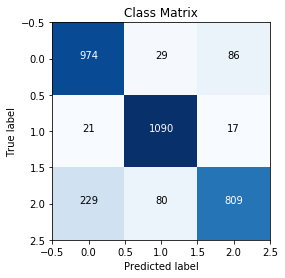

In [31]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': [3,4,5,6,7,8,9,10,11,15]}
est, cls, scr = gridsearchCV(gX_rsW_ada, gy_rsW_ada, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': [3,4,5,6,7,8,9,10,11,15]}
est, cls, scr = gridsearchCV(gX_rsW_ada, gy_rsW_ada, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

### Random Forest Classifier

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 100, 'forest__random_state': 2}
Tuned balanced accuracy 0.3996416653806916
              precision    recall  f1-score   support

           0       0.75      0.19      0.31       317
           1       0.00      0.00      0.00        45
           2       0.78      0.98      0.87      1108

   micro avg       0.78      0.78      0.78      1470
   macro avg       0.51      0.39      0.39      1470
weighted avg       0.75      0.78      0.72      1470

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 6, 'forest__max_depth': 6, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 100, 'forest__random_state': 2}
Tuned balanced accuracy 0.40533778379750346
              precision    recall  f1-score   support

           0       0.72      0.23      0.35       317
           

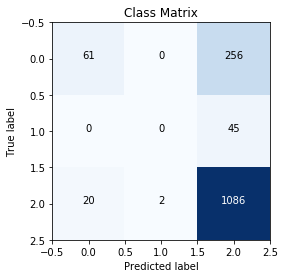

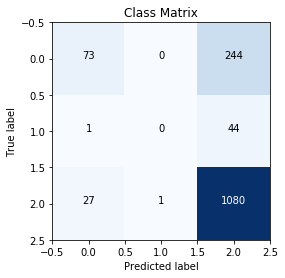

In [32]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(__Xw, Yw,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(__Xw, Yw,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### Random Forest: imblearn

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__min_samples_leaf': 1, 'forest__n_estimators': 100, 'forest__random_state': 2}
Tuned balanced accuracy 0.6877398483378319
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1078
           1       0.81      0.75      0.78      1103
           2       0.58      0.58      0.58      1109

   micro avg       0.69      0.69      0.69      3290
   macro avg       0.69      0.69      0.69      3290
weighted avg       0.69      0.69      0.69      3290

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 6, 'forest__max_depth': 6, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 100, 'forest__random_state': 2}
Tuned balanced accuracy 0.6087846983799725
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       632
           1

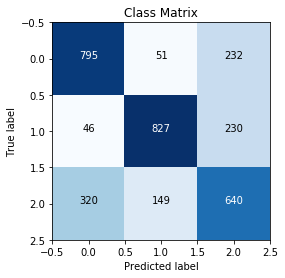

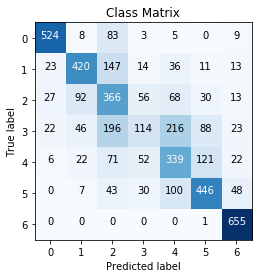

In [33]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(gX_rsW_smt, gy_rsW_smt,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(X_rsW_smt, y_rsW_smt,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 100, 'forest__random_state': 2}
Tuned balanced accuracy 0.683064301530209
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1089
           1       0.80      0.76      0.78      1128
           2       0.58      0.56      0.57      1118

   micro avg       0.69      0.69      0.69      3335
   macro avg       0.69      0.69      0.69      3335
weighted avg       0.69      0.69      0.69      3335

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 6, 'forest__max_depth': 6, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 100, 'forest__random_state': 2}
Tuned balanced accuracy 0.6705415546934105
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1089
           1 

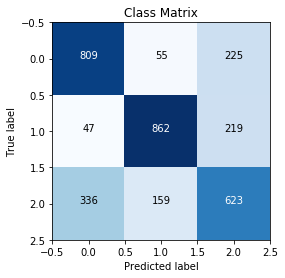

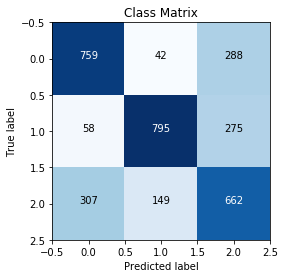

In [34]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(gX_rsW_ada, gy_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
param_grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [100],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': n_leaf}
est, cls, scr = gridsearchCV(gX_rsW_ada, gy_rsW_ada,steps,param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### Support Vector Machines

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 1, 'SVM__gamma': 1}
Tuned balanced accuracy 0.5750742282278806
              precision    recall  f1-score   support

           0       0.46      0.71      0.56       317
           1       0.17      0.27      0.21        45
           2       0.87      0.72      0.79      1108

   micro avg       0.71      0.71      0.71      1470
   macro avg       0.50      0.57      0.52      1470
weighted avg       0.76      0.71      0.72      1470

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 5, 'SVM__C': 15, 'SVM__gamma': 10}
Tuned balanced accuracy 0.4883317974283684
              precision    recall  f1-score   support

           0       0.50      0.48      0.49       317
           1       0.20      0.18      0.19        45
           2       0.83      0.84      0.84      1108

   micro avg       0.74      0.74      0.74      1470
   macro avg       0.51      0.50      0.50      1470
w

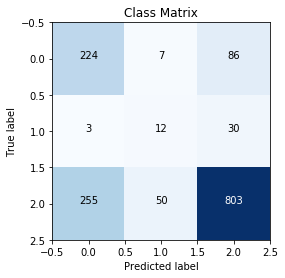

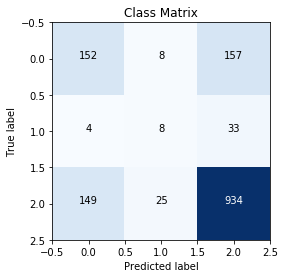

In [35]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo', kernel='rbf',
                     class_weight='balanced', probability=True, cache_size=800))]
# Specify the hyperparameter space
parameters = {'SVM__C': c_svm,
              'SVM__gamma' : g_space}
est, cls, scr = gridsearchCV(__Xw, Yw,steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo', class_weight='balanced', 
                     probability=True, kernel='rbf', cache_size=800))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': [3,4,5,6],
              'SVM__C': c_svm,
              'SVM__gamma': g_space}
est, cls, scr = gridsearchCV(__Xw, Yw,steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

##### Linear Support Vector Machines: imblearn

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 15, 'SVM__gamma': 10}
Tuned balanced accuracy 0.8846364501434
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1078
           1       0.98      0.94      0.96      1103
           2       0.79      0.93      0.86      1109

   micro avg       0.89      0.89      0.89      3290
   macro avg       0.90      0.89      0.89      3290
weighted avg       0.90      0.89      0.89      3290

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 6, 'SVM__C': 15, 'SVM__gamma': 10}
Tuned balanced accuracy 0.8686004408142681
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1078
           1       0.97      0.95      0.96      1103
           2       0.84      0.83      0.84      1109

   micro avg       0.89      0.89      0.89      3290
   macro avg       0.89      0.89      0.89      3290
we

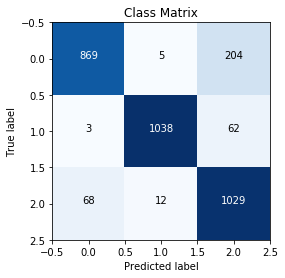

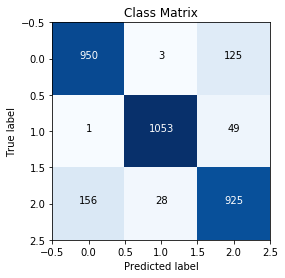

In [36]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo', kernel='rbf',
                     class_weight='balanced', probability=True, cache_size=800))]
# Specify the hyperparameter space
parameters = {'SVM__C': c_svm,
              'SVM__gamma' : g_space}
est, cls, scr = gridsearchCV(gX_rsW_svm, gy_rsW_svm, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo', class_weight='balanced', 
                     probability=True, kernel='rbf', cache_size=800))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': [3,4,5,6],
              'SVM__C': c_svm,
              'SVM__gamma': g_space}
est, cls, scr = gridsearchCV(gX_rsW_svm, gy_rsW_svm, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Parameters':est.steps[1][1], 
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 15, 'SVM__gamma': 1}
Tuned balanced accuracy 0.8488702240052421
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1089
           1       0.93      0.98      0.95      1128
           2       0.87      0.75      0.81      1118

   micro avg       0.87      0.87      0.87      3335
   macro avg       0.87      0.87      0.87      3335
weighted avg       0.87      0.87      0.87      3335

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 6, 'SVM__C': 15, 'SVM__gamma': 10}
Tuned balanced accuracy 0.8397278055642186
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1089
           1       0.93      0.95      0.94      1128
           2       0.85      0.77      0.81      1118

   micro avg       0.87      0.87      0.87      3335
   macro avg       0.87      0.87      0.86      3335


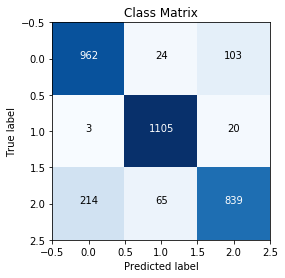

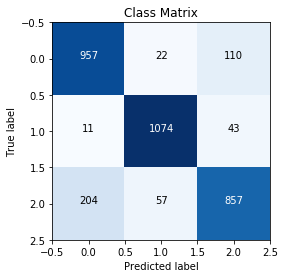

In [38]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo', kernel='rbf',
                     class_weight='balanced', probability=True, cache_size=800))]
# Specify the hyperparameter space
parameters = {'SVM__C': c_svm,
              'SVM__gamma' : g_space}
est, cls, scr = gridsearchCV(gX_rsW_ada, gy_rsW_ada, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo', class_weight='balanced', 
                     probability=True, kernel='rbf', cache_size=800))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': [3,4,5,6],
              'SVM__C': c_svm,
              'SVM__gamma': g_space}
est, cls, scr = gridsearchCV(gX_rsW_ada, gy_rsW_ada, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
w_results = w_results.append(df_scratch)

In [39]:
w_results.to_csv('./data/w_wine_results.csv')

In [4]:
dfw = pd.read_csv('./data/w_wine_results.csv')
dfw.index = dfw.Classes 
dfw = dfw.drop(['Unnamed: 0'], axis=1)
dfw.groupby(['Classes', 'Estimator']).max()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'Classes' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


Balanced Accuracy  \
Classes  Estimator                                                               
Grouped  <class 'sklearn.ensemble.forest.RandomForestCla...           0.687740   
         <class 'sklearn.linear_model.logistic.LogisticR...           0.614242   
         <class 'sklearn.neighbors.classification.KNeigh...           0.836586   
         <class 'sklearn.svm.classes.SVC'>                            0.884636   
Original <class 'sklearn.ensemble.forest.RandomForestCla...           0.613536   
         <class 'sklearn.linear_model.logistic.LogisticR...           0.426771   
         <class 'sklearn.neighbors.classification.KNeigh...           0.826718   
         <class 'sklearn.svm.classes.SVC'>                            0.815944   

                                                            Sampling  \
Classes  Estimator                                                     
Grouped  <class 'sklearn.ensemble.forest.RandomForestCla...       no   
         <class 'sklearn.linear_model.logistic.LogisticR...       no   
         <class 'sklearn.neighbors.classification.KNeigh...       no   
         <class 'sklearn.svm.classes.SVC'>                        no   
Original <class 'sklearn.ensemble.forest.RandomForestCla...       no   
         <class 'sklearn.linear_model.logistic.LogisticR...    SMOTE   
         <class 'sklearn.neighbors.classification.KNeigh...       no   
         <class 'sklearn.svm.classes.SVC'>                        no   

                                                            Transformation  
Classes  Estimator                                                          
Grouped  <class 'sklearn.ensemble.forest.RandomForestCla...         scaler  
         <class 'sklearn.linear_model.logistic.LogisticR...         scaler  
         <class 'sklearn.neighbors.classification.KNeigh...          Scale  
         <class 'sklearn.svm.classes.SVC'>                          scaler  
Original <class 'sklearn.ensemble.forest.RandomForestCla...         scaler  
         <class 'sklearn.linear_model.logistic.LogisticR...         scaler  
         <class 'sklearn.neighbors.classification.KNeigh...          Scale  
         <class 'sklearn.svm.classes.SVC'>                          scaler

# Red wine quality classification

From the ANOVA we can see residual sugar is the only feature which has equal variance and mean amongst all quality levels. This tells us `resid_sugar` is the worse feature and will corrupt any model. From the Tukey's comparison of means we observe red wine's most divisive features are `sulphates`, `citric_acid`, and, `vol_acidity`.The others are questionable due to the them having equal means among some comparisons. After performing a PCA analysis we will evaluate which features to throw away yet it should be noted that features with low difference of means will be first in line: `density`.

In [40]:
# label encoding of groups
# encode labels with value between 0 and n_classes-1.
le = LabelEncoder()

# force pandas to behave like a dataframe by passing a list of columns for the one hot
yr = redn.group.values #le.fit_transform(redn[['group']])
Xr = redn.drop(['group', 'quality'], axis = 1)

# Feature engineering continued
From the PCA plot below we can see the colinearity of the features from the red wine dataset. We can see that `chlorides`, and `density`  are highly correlated so trash `density`. As well as `free_sul_dioxide` and `total_SD` so we trash `total_SD`. And the same is for `fixed_acidity`, `citric_acid`,  and `sulphates` so we trash `fixed_acidity`. The trash features are the features which had the lowest mean difference from the comparison of mean. From Tukey's comparision of means we know the most divisive features are `vol_acidity`, `citric_acid`, and `sulphates` which is why those were kept. We choose to leave ditch `resid_sugar` because it failed the ANOVA and all of the Tukey's comparison of means.

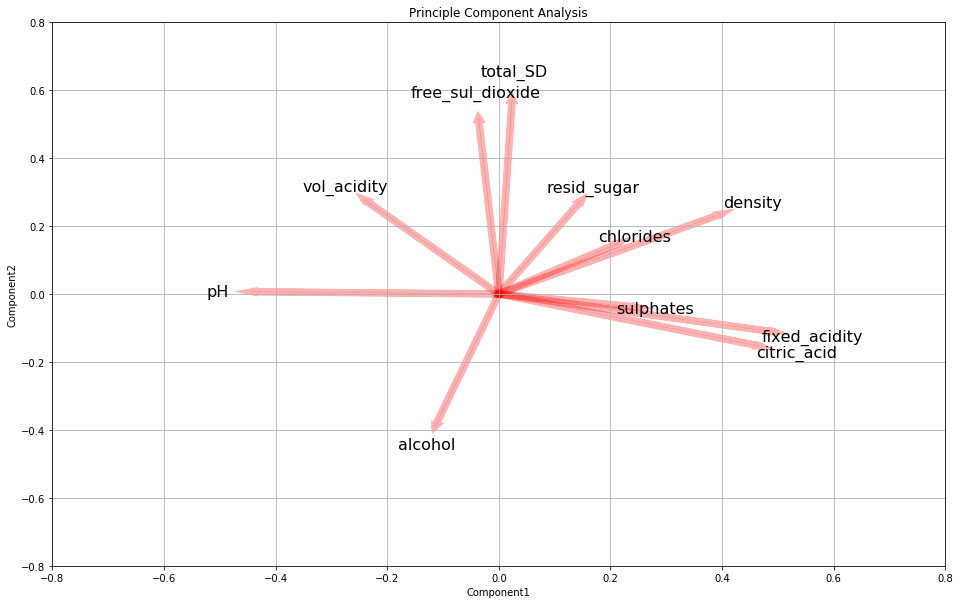

In [41]:
#Call the function. Use only the 2 PCs.
PCAplot(Xr,labels=Xr.columns.tolist(), ax=plt.subplots(figsize=(16,10)))
plt.savefig('R_pca1.png', dpi=300)

In [42]:
__Xr = Xr.copy()
__Xr = __Xr.drop(['free_sul_dioxide', 'density', 'fixed_acidity', 'resid_sugar'], axis = 1)

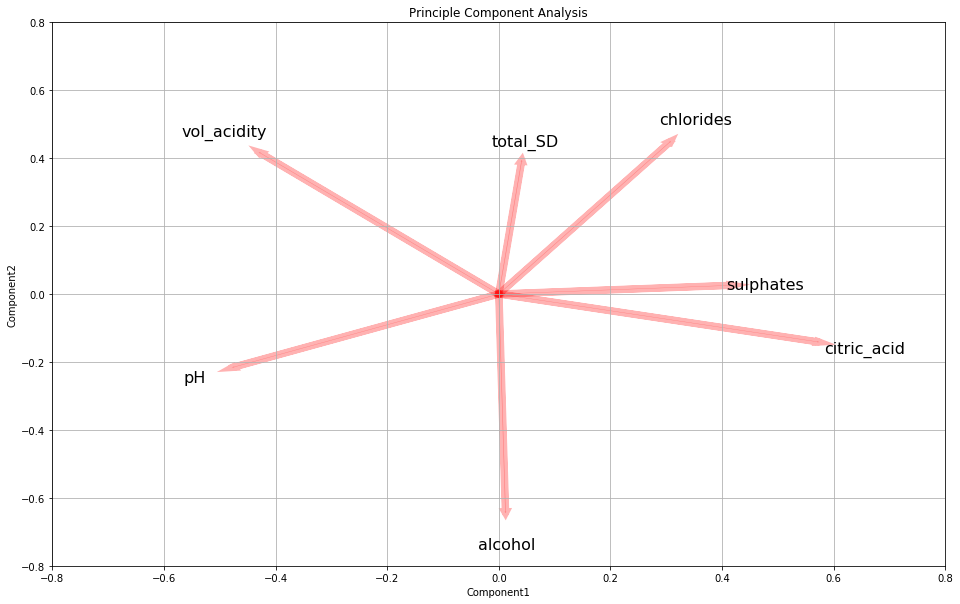

In [43]:
#Call the function. Use only the 2 PCs.
PCAplot(__Xr,labels=__Xr.columns.tolist(), ax=plt.subplots(figsize=(16,10)))
plt.savefig('R_pca2.png', dpi=300)

In [44]:
# Using original labels sampling 
X_rsR_smt, y_rsR_smt = SMOTE().fit_resample(__Xr, redn.quality.values)
# ValueError: No samples will be generated with the provided ratio settings.
#X_rsR_ada, y_rsR_ada = ADASYN(,n_jobs=-1).fit_resample(__Xr, redn.quality.values)

# Grouping sampling  
gX_rsR_smt, gy_rsR_smt = SMOTE(k_neighbors=2,n_jobs=-1).fit_resample(__Xr, yr)
gX_rsR_ada, gy_rsR_ada = ADASYN(n_neighbors=2,n_jobs=-1).fit_resample(__Xr, yr)
# sampling for support vector machines
gX_rsR_svm, gy_rsR_svm = SVMSMOTE(k_neighbors=2,n_jobs=-1).fit_resample(__Xr, yr)

In [45]:
# DataFrame to keep score for best classifier
Red_scores = pd.DataFrame()

# Classify using original labels

### Logistic Regression
Using the analysis of colinearity between features to attempt in improving the model was not useful and did not improve logistic regression. From the results below we can see that it did not improve classification for any of the wine types. Logistic regression appears to only be good at classifying one type of wine. 

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 10.0, 'reg__random_state': 0}
Tuned balanced accuracy 0.29270774879187095
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        16
           2       0.65      0.71      0.68       207
           3       0.50      0.61      0.55       186
           4       0.48      0.17      0.26        63
           5       0.00      0.00      0.00         6

   micro avg       0.56      0.56      0.56       480
   macro avg       0.27      0.25      0.25       480
weighted avg       0.54      0.56      0.54       480

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'PCA__n_components': 4, 'reg__C': 10.0, 'reg__random_state': 0}
Tuned balanced accuracy 0.2585702528948428
              precision    recall  f1-score   support

           0       0.00      0.00      0.

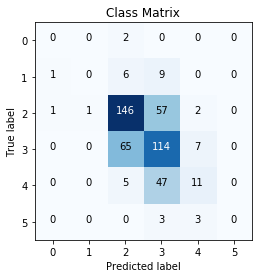

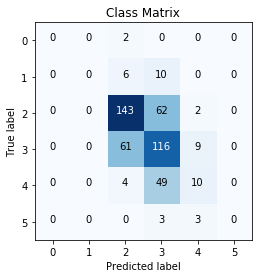

In [46]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'reg__C': c_space,
              'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(__Xr, redn.quality.values, steps, param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'PCA__n_components': n_features_to_test,
              'reg__C': c_space,
              'reg__random_state': [0,7]}
est, cls, scr = gridsearchCV(__Xr, redn.quality.values, steps, param_grid,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

##### Logistic Regression: imblearn

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 2.1544346900318834, 'reg__random_state': 0}
Tuned balanced accuracy 0.5749581161793804
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       202
           1       0.55      0.53      0.54       202
           2       0.54      0.51      0.53       206
           3       0.46      0.41      0.43       203
           4       0.41      0.39      0.40       192
           5       0.67      0.74      0.70       221

   micro avg       0.58      0.58      0.58      1226
   macro avg       0.56      0.57      0.57      1226
weighted avg       0.57      0.58      0.57      1226

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'PCA__n_components': 6, 'reg__C': 2.1544346900318834, 'reg__random_state': 0}
Tuned balanced accuracy 0.5083591713601784
              precision    recall  f1-score   support

           0  

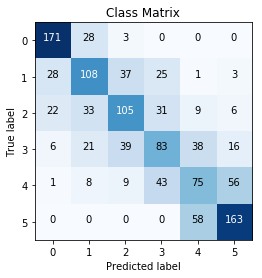

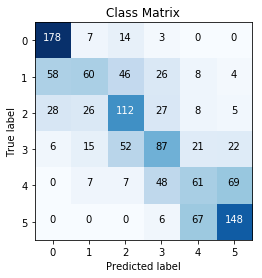

In [47]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'reg__C': c_space,
              'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(X_rsR_smt, y_rsR_smt, steps, param_grid,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'PCA__n_components': n_features_to_test,
              'reg__C': c_space,
              'reg__random_state': [0,7]}
est, cls, scr = gridsearchCV(X_rsR_smt, y_rsR_smt, steps, param_grid,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

### KNeighbors Classifier
We expect clustering algorithms to work best on grouped classed yet we evaluate all other forms of the dataset using K nearest neighbors classifing. 


Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 4, 'K__weights': 'distance'}
Tuned balanced accuracy 0.3205494059668461
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.12      0.20        16
           2       0.71      0.68      0.69       207
           3       0.55      0.64      0.59       186
           4       0.56      0.52      0.54        63
           5       0.00      0.00      0.00         6

   micro avg       0.61      0.61      0.61       480
   macro avg       0.39      0.33      0.34       480
weighted avg       0.61      0.61      0.61       480

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 3, 'K__weights': 'distance', 'PCA__n_components': 6}
Tuned balanced accuracy 0.2980978947050619
              precision    recall  f1-score   support

           0      

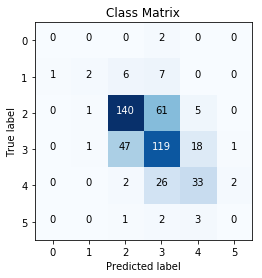

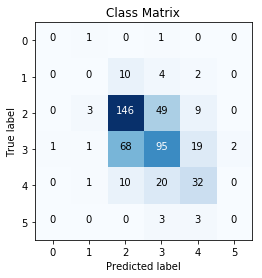

In [48]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(__Xr, redn.quality.values, steps,parameters,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(__Xr, redn.quality.values, steps,parameters,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

#### K Neighbors: imblearn

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform'}
Tuned balanced accuracy 0.8236759411854151
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       202
           1       0.85      0.96      0.90       202
           2       0.67      0.58      0.62       206
           3       0.62      0.56      0.59       203
           4       0.82      0.84      0.83       192
           5       0.94      1.00      0.97       221

   micro avg       0.82      0.82      0.82      1226
   macro avg       0.81      0.82      0.82      1226
weighted avg       0.82      0.82      0.82      1226

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform', 'PCA__n_components': 6}
Tuned balanced accuracy 0.7526342103749883
              precision    recall  f1-score   support

           0       0

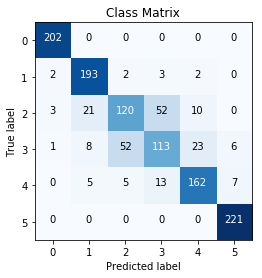

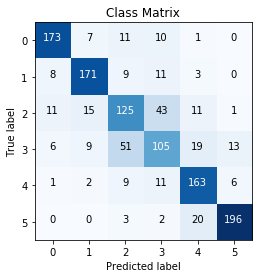

In [49]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(X_rsR_smt, y_rsR_smt, steps,parameters,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':"SMOTE",
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(X_rsR_smt, y_rsR_smt, steps,parameters,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0],"Sampling":'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

### Random Forests

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__max_features': 6, 'forest__min_samples_leaf': 3, 'forest__n_estimators': 200, 'forest__random_state': 2}
Tuned balanced accuracy 0.2921755915163416
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        16
           2       0.68      0.73      0.71       207
           3       0.52      0.66      0.58       186
           4       0.67      0.22      0.33        63
           5       0.00      0.00      0.00         6

   micro avg       0.60      0.60      0.60       480
   macro avg       0.31      0.27      0.27       480
weighted avg       0.58      0.60      0.57       480

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 4, 'forest__max_depth': 6, 'forest__min_samples_leaf': 3, 'forest__n_estimators': 200, 'f

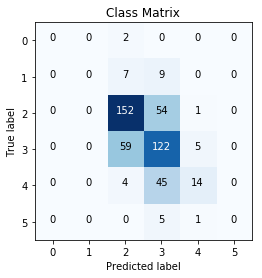

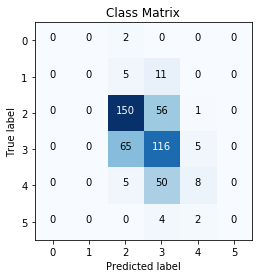

In [50]:
n_features_to_test = np.arange(3,7)
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier())]
pipeline = Pipeline(steps)
grid = {'forest__n_estimators': [200],
        'forest__max_features': n_features_to_test,
        'forest__random_state': [2],
        'forest__max_depth': depth,
        'forest__min_samples_leaf' : [2,3]}
est, cls, scr = gridsearchCV(__Xr,redn.quality.values, steps, grid,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)
grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [200],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': [2,3]}
est, cls, scr = gridsearchCV(__Xr, redn.quality.values, steps, grid,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

##### Random Forest: imblearn

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__max_features': 3, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 200, 'forest__random_state': 2}
Tuned balanced accuracy 0.7199060358615361
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       202
           1       0.69      0.74      0.72       202
           2       0.57      0.63      0.60       206
           3       0.55      0.36      0.44       203
           4       0.61      0.61      0.61       192
           5       0.84      0.90      0.87       221

   micro avg       0.70      0.70      0.70      1226
   macro avg       0.69      0.70      0.69      1226
weighted avg       0.69      0.70      0.69      1226

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 6, 'forest__max_depth': 6, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 200, 'f

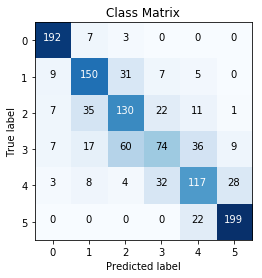

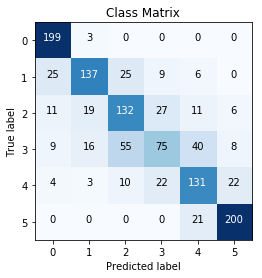

In [51]:
n_features_to_test = np.arange(3,7)
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier())]
pipeline = Pipeline(steps)
grid = {'forest__n_estimators': [200],
        'forest__max_features': n_features_to_test,
        'forest__random_state': [2],
        'forest__max_depth': depth,
        'forest__min_samples_leaf' : [2,3]}
est, cls, scr = gridsearchCV(X_rsR_smt, y_rsR_smt, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)
grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [200],
        'forest__max_depth': depth,
        'forest__min_samples_leaf': [2,3]}
est, cls, scr = gridsearchCV(X_rsR_smt, y_rsR_smt, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

### Support Vector Machines

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 15, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.3077342179081546
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.25      0.33        16
           2       0.68      0.71      0.69       207
           3       0.56      0.62      0.59       186
           4       0.67      0.44      0.53        63
           5       0.25      0.17      0.20         6

   micro avg       0.61      0.61      0.61       480
   macro avg       0.44      0.37      0.39       480
weighted avg       0.61      0.61      0.61       480

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 5, 'SVM__C': 15, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.29600280602038637
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           

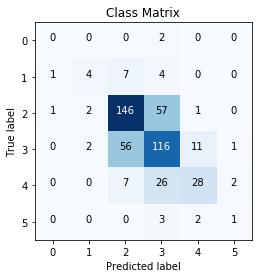

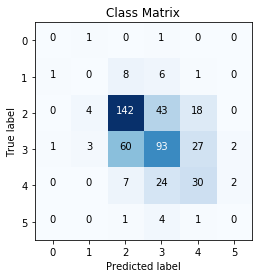

In [52]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'SVM__C': c_svm,
              'SVM__kernel': ['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(__Xr,redn.quality.values,steps,parameters,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'SVM__C': c_svm,                          
              'SVM__kernel':['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(__Xr,redn.quality.values,steps,parameters,plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

##### SVM: imblearn

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 15, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.8254913684516125
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       202
           1       0.86      0.94      0.90       202
           2       0.63      0.62      0.63       206
           3       0.64      0.59      0.61       203
           4       0.87      0.79      0.83       192
           5       0.94      1.00      0.97       221

   micro avg       0.82      0.82      0.82      1226
   macro avg       0.82      0.82      0.82      1226
weighted avg       0.82      0.82      0.82      1226

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 6, 'SVM__C': 15, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.7562855699396719
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       202
           1

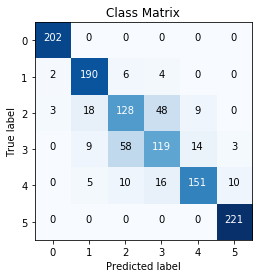

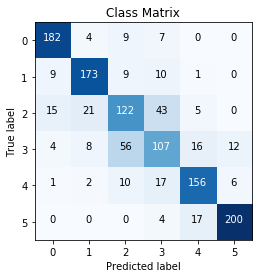

In [53]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'SVM__C': c_svm,
              'SVM__kernel':['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(X_rsR_smt, y_rsR_smt,steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'SVM__C': c_svm,                          
              'SVM__kernel':['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(X_rsR_smt, y_rsR_smt,steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Original','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Classify using grouped labels


### Logistic Regression
Using the analysis of colinearity between features to attempt in improving the model was not useful and did not improve logistic regression. From the results below we can see that it did not improve classification for any of the wine types. Logistic regression appears to only be good at classifying one type of wine. 

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.46415888336127786, 'reg__random_state': 0}
Tuned balanced accuracy 0.4404218556003729
              precision    recall  f1-score   support

           0       0.58      0.20      0.30        69
           1       0.00      0.00      0.00        18
           2       0.84      0.97      0.90       393

   micro avg       0.82      0.82      0.82       480
   macro avg       0.47      0.39      0.40       480
weighted avg       0.77      0.82      0.78       480

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'PCA__n_components': 6, 'reg__C': 46.415888336127729, 'reg__random_state': 0}
Tuned balanced accuracy 0.4117352307042768
              precision    recall  f1-score   support

           0       0.65      0.19      0.29        69
           1       0.00      0.00      0.00        18
           2       0.84      0.98      0.91       393

   micro avg

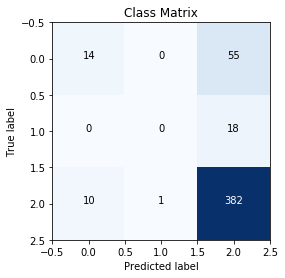

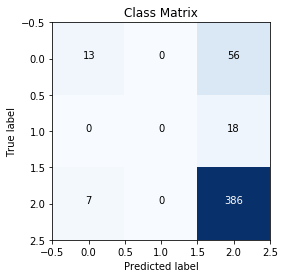

In [54]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'reg__C': c_space,
              'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(__Xr,yr, steps, param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs'))]
# Setup the hyperparameter grid
c_space = np.logspace(-5, 7, 10)
param_grid = {'PCA__n_components': n_features_to_test,
              'reg__C': c_space,
              'reg__random_state': [0,7]}
est, cls, scr = gridsearchCV(__Xr,yr, steps, param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

#### Logistic Regression: imblearn

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.10000000000000001, 'reg__random_state': 0}
Tuned balanced accuracy 0.7185168752529438
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       399
           1       0.73      0.74      0.73       395
           2       0.57      0.56      0.57       394

   micro avg       0.70      0.70      0.70      1188
   macro avg       0.70      0.70      0.70      1188
weighted avg       0.70      0.70      0.70      1188

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'PCA__n_components': 6, 'reg__C': 46.415888336127729, 'reg__random_state': 0}
Tuned balanced accuracy 0.7077112912997787
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       399
           1       0.70      0.75      0.73       395
           2       0.61      0.53      0.56       394

   micro avg

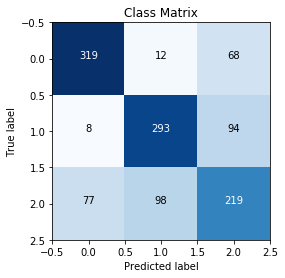

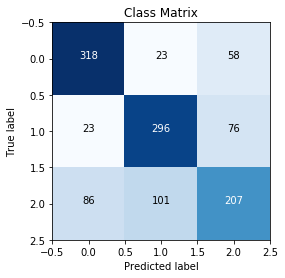

In [55]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'reg__C': c_space,
              'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(gX_rsR_smt, gy_rsR_smt, steps, param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs'))]
# Setup the hyperparameter grid
c_space = np.logspace(-5, 7, 10)
param_grid = {'PCA__n_components': n_features_to_test,
              'reg__C': c_space,
              'reg__random_state': [0,7]}
est, cls, scr = gridsearchCV(gX_rsR_smt, gy_rsR_smt, steps, param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'SMOTE',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'reg__C': 0.10000000000000001, 'reg__random_state': 0}
Tuned balanced accuracy 0.7085620043444975
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       395
           1       0.72      0.80      0.76       408
           2       0.61      0.52      0.56       401

   micro avg       0.71      0.71      0.71      1204
   macro avg       0.70      0.71      0.70      1204
weighted avg       0.70      0.71      0.70      1204

Model: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Tuned Parameters: {'PCA__n_components': 6, 'reg__C': 46.415888336127729, 'reg__random_state': 0}
Tuned balanced accuracy 0.6965851515783678
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       395
           1       0.69      0.80      0.74       408
           2       0.64      0.46      0.53       401

   micro avg

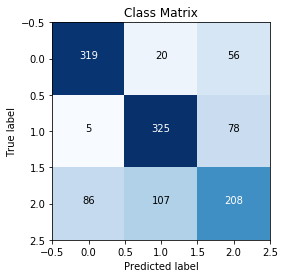

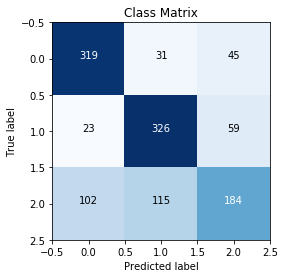

In [56]:
steps = [('scaler', StandardScaler()),
         ('reg', LogisticRegression(solver='lbfgs',multi_class='multinomial'))]
param_grid = {'reg__C': c_space,
              'reg__random_state': [0,3,4,7]}
est, cls, scr = gridsearchCV(gX_rsR_ada, gy_rsR_ada, steps, param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('reg', LogisticRegression(solver='lbfgs'))]
# Setup the hyperparameter grid
c_space = np.logspace(-5, 7, 10)
param_grid = {'PCA__n_components': n_features_to_test,
              'reg__C': c_space,
              'reg__random_state': [0,7]}
est, cls, scr = gridsearchCV(gX_rsR_ada, gy_rsR_ada, steps, param_grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]),
                                "Transformation":est.steps[0][0], 'Sampling':'ADASYN',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

##### K Neighbors: imblearn

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 2, 'K__weights': 'uniform'}
Tuned balanced accuracy 0.5668155243966319
              precision    recall  f1-score   support

           0       0.46      0.72      0.56        69
           1       0.24      0.44      0.31        18
           2       0.92      0.79      0.85       393

   micro avg       0.77      0.77      0.77       480
   macro avg       0.54      0.65      0.57       480
weighted avg       0.83      0.77      0.79       480

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 2, 'K__weights': 'uniform', 'PCA__n_components': 5}
Tuned balanced accuracy 0.5434926990956378
              precision    recall  f1-score   support

           0       0.37      0.62      0.47        69
           1       0.17      0.22      0.20        18
           2       0.89      0.78      0.83       393

   micro avg       

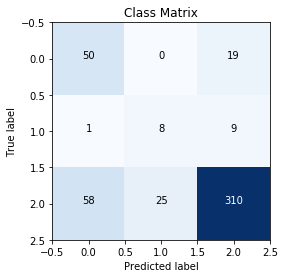

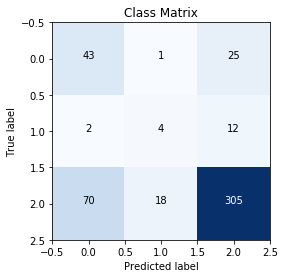

In [57]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(__Xr, yr, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'no',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(__Xr, yr, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 
                                "Transformation":est.steps[0][0], 'Sampling':'no',
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

##### K Neighbors: imblearn

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform'}
Tuned balanced accuracy 0.9094965461009552
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       399
           1       0.93      0.99      0.96       395
           2       0.95      0.82      0.88       394

   micro avg       0.93      0.93      0.93      1188
   macro avg       0.93      0.92      0.92      1188
weighted avg       0.93      0.93      0.92      1188

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform', 'PCA__n_components': 6}
Tuned balanced accuracy 0.8950495080317492
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       399
           1       0.93      0.96      0.95       395
           2       0.93      0.84      0.88       394

   micro avg       

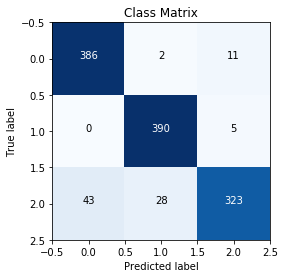

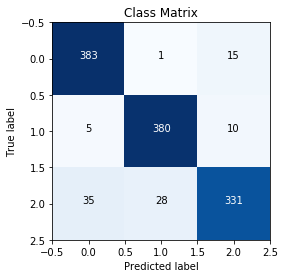

In [58]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(gX_rsR_smt, gy_rsR_smt, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'SMOTE',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(gX_rsR_smt, gy_rsR_smt, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'SMOTE',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform'}
Tuned balanced accuracy 0.901520187475061
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       395
           1       0.93      1.00      0.96       408
           2       0.97      0.80      0.88       401

   micro avg       0.92      0.92      0.92      1204
   macro avg       0.93      0.92      0.92      1204
weighted avg       0.93      0.92      0.92      1204

Model: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Tuned Parameters: {'K__n_neighbors': 1, 'K__weights': 'uniform', 'PCA__n_components': 5}
Tuned balanced accuracy 0.8972603422870258
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       395
           1       0.93      0.98      0.95       408
           2       0.96      0.82      0.88       401

   micro avg       0

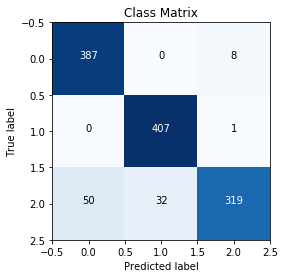

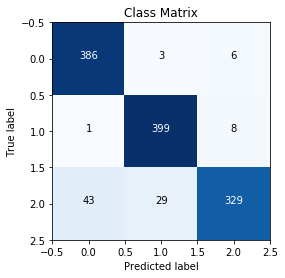

In [59]:
# Setup the pipeline
steps = [('Scale', StandardScaler()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(gX_rsR_ada, gy_rsR_ada, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'ADASYN',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('K', KNeighborsClassifier(n_jobs=-1))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'K__weights':['uniform', 'distance'],
              'K__n_neighbors': k_space}
est, cls, scr = gridsearchCV(gX_rsR_ada, gy_rsR_ada, steps,parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'ADASYN',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

### Random Forests

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__max_features': 5, 'forest__min_samples_leaf': 3, 'forest__n_estimators': 200, 'forest__random_state': 2}
Tuned balanced accuracy 0.45145970140776215
              precision    recall  f1-score   support

           0       0.63      0.25      0.35        69
           1       0.50      0.06      0.10        18
           2       0.85      0.97      0.91       393

   micro avg       0.83      0.83      0.83       480
   macro avg       0.66      0.42      0.45       480
weighted avg       0.80      0.83      0.80       480

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 4, 'forest__max_depth': 5, 'forest__min_samples_leaf': 3, 'forest__n_estimators': 200, 'forest__random_state': 2}
Tuned balanced accuracy 0.4224241952028063
              precision    recall  f1-score   support

           0       0.82      0.13     

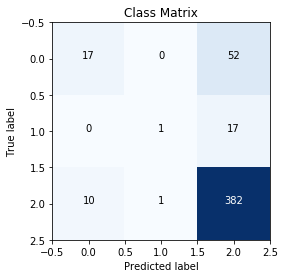

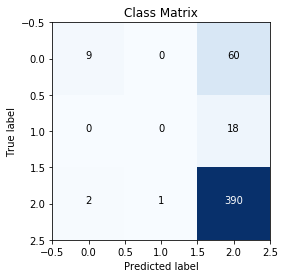

In [60]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
grid = {'forest__n_estimators': [200],
        'forest__max_features': n_features_to_test,
        'forest__random_state': [2],
        'forest__max_depth': depth,
        'forest__min_samples_leaf' : [2,3]}
est, cls, scr = gridsearchCV(__Xr, yr, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'no',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [200],
        'forest__max_depth': [4,5],
        'forest__min_samples_leaf': [2,3]}
est, cls, scr = gridsearchCV(__Xr, yr, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'no',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

##### Random Forests: imblearn

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__max_features': 3, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 200, 'forest__random_state': 2}
Tuned balanced accuracy 0.8210385723704768
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       399
           1       0.86      0.88      0.87       395
           2       0.78      0.71      0.75       394

   micro avg       0.83      0.83      0.83      1188
   macro avg       0.83      0.83      0.83      1188
weighted avg       0.83      0.83      0.83      1188

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 6, 'forest__max_depth': 5, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 200, 'forest__random_state': 2}
Tuned balanced accuracy 0.7827821792304339
              precision    recall  f1-score   support

           0       0.82      0.86      

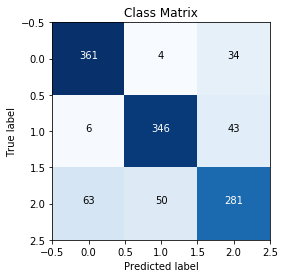

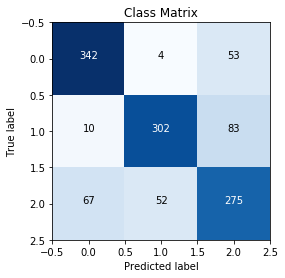

In [61]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
grid = {'forest__n_estimators': [200],
        'forest__max_features': n_features_to_test,
        'forest__random_state': [2],
        'forest__max_depth': depth,
        'forest__min_samples_leaf' : [2,3]}
est, cls, scr = gridsearchCV(gX_rsR_smt, gy_rsR_smt, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'SMOTE',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [200],
        'forest__max_depth': [4,5],
        'forest__min_samples_leaf': [2,3]}
est, cls, scr = gridsearchCV(gX_rsR_smt, gy_rsR_smt, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'SMOTE',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'forest__max_depth': 6, 'forest__max_features': 3, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 200, 'forest__random_state': 2}
Tuned balanced accuracy 0.8182894942514954
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       395
           1       0.83      0.90      0.86       408
           2       0.84      0.63      0.72       401

   micro avg       0.82      0.82      0.82      1204
   macro avg       0.82      0.82      0.81      1204
weighted avg       0.82      0.82      0.81      1204

Model: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Tuned Parameters: {'PCA__n_components': 6, 'forest__max_depth': 5, 'forest__min_samples_leaf': 2, 'forest__n_estimators': 200, 'forest__random_state': 2}
Tuned balanced accuracy 0.7926401461638438
              precision    recall  f1-score   support

           0       0.77      0.93      

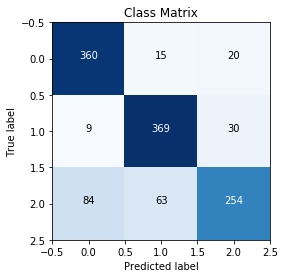

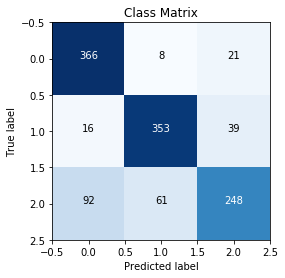

In [62]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
grid = {'forest__n_estimators': [200],
        'forest__max_features': n_features_to_test,
        'forest__random_state': [2],
        'forest__max_depth': depth,
        'forest__min_samples_leaf' : [2,3]}
est, cls, scr = gridsearchCV(gX_rsR_ada, gy_rsR_ada, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'ADASYN',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline steps: steps
steps = [('PCA', PCA()),
         ('forest', RandomForestClassifier(n_jobs=-1))]
grid = {'PCA__n_components': n_features_to_test,
        'forest__random_state': [2],
        'forest__n_estimators': [200],
        'forest__max_depth': [4,5],
        'forest__min_samples_leaf': [2,3]}
est, cls, scr = gridsearchCV(gX_rsR_ada, gy_rsR_ada, steps, grid, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'ADASYN',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

### Support Vector Machines

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 1, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.5553960568645736
              precision    recall  f1-score   support

           0       0.56      0.64      0.59        69
           1       0.21      0.22      0.22        18
           2       0.90      0.88      0.89       393

   micro avg       0.82      0.82      0.82       480
   macro avg       0.56      0.58      0.57       480
weighted avg       0.83      0.82      0.82       480

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 4, 'SVM__C': 1, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.5356302359989308
              precision    recall  f1-score   support

           0       0.37      0.67      0.48        69
           1       0.11      0.22      0.15        18
           2       0.89      0.73      0.80       393

   micro avg       0.70      0.70      0.70       480
   macro avg 

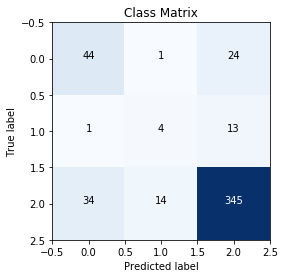

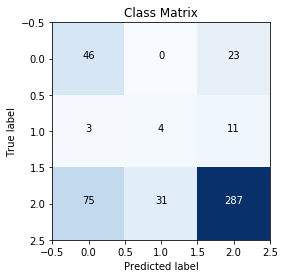

In [63]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'SVM__C': c_svm,
              'SVM__kernel': ['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(__Xr, yr, steps, parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'no',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'SVM__C': c_svm,                          
              'SVM__kernel': ['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(__Xr, yr,steps, parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'no',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

##### SVM: imblearn

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 15, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.9183762164807507
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       404
           1       0.94      0.95      0.94       193
           2       0.91      0.91      0.91       370

   micro avg       0.93      0.93      0.93       967
   macro avg       0.93      0.93      0.93       967
weighted avg       0.93      0.93      0.93       967

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 6, 'SVM__C': 15, 'SVM__gamma': 10, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.9292410189942556
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       404
           1       0.98      0.95      0.97       193
           2       0.92      0.96      0.94       370

   micro avg       0.95      0.95      0.95       967
   macro a

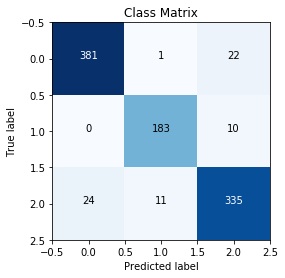

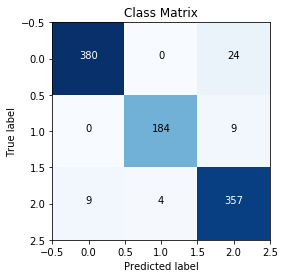

In [64]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'SVM__C': c_svm,
              'SVM__kernel': ['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(gX_rsR_svm, gy_rsR_svm, steps, parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'SMOTE',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'SVM__C': c_svm,                          
              'SVM__kernel': ['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(gX_rsR_svm, gy_rsR_svm, steps, parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'SMOTE',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'SVM__C': 15, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.922312016213007
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       395
           1       0.95      1.00      0.97       408
           2       0.95      0.86      0.91       401

   micro avg       0.94      0.94      0.94      1204
   macro avg       0.94      0.94      0.94      1204
weighted avg       0.94      0.94      0.94      1204

Model: <class 'sklearn.svm.classes.SVC'>
Tuned Parameters: {'PCA__n_components': 6, 'SVM__C': 15, 'SVM__gamma': 10, 'SVM__kernel': 'rbf'}
Tuned balanced accuracy 0.908141221437331
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       395
           1       0.99      0.95      0.97       408
           2       0.92      0.96      0.94       401

   micro avg       0.96      0.96      0.96      1204
   macro avg

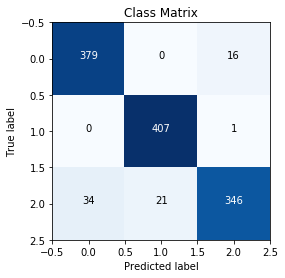

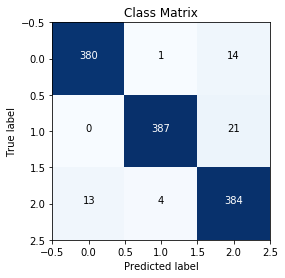

In [65]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'SVM__C': c_svm,
              'SVM__kernel': ['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(gX_rsR_ada, gy_rsR_ada, steps, parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'ADASYN',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

# Setup the pipeline
steps = [('PCA', PCA()),
         ('SVM', SVC(decision_function_shape='ovo',
                     probability=True, class_weight='balanced', cache_size=800))]
# Specify the hyperparameter space
parameters = {'PCA__n_components': n_features_to_test,
              'SVM__C': c_svm,                          
              'SVM__kernel': ['rbf'],
              'SVM__gamma':g_space}
est, cls, scr = gridsearchCV(gX_rsR_ada, gy_rsR_ada, steps, parameters, plt_mat=True)
df_scratch = pd.DataFrame(data={'Estimator':type(est.steps[1][1]), 'Sampling':'ADASYN',
                                "Transformation":est.steps[0][0],
                                'Classes':'Grouped','Balanced Accuracy':scr}, index=[0])
Red_scores = Red_scores.append(df_scratch)

In [66]:
Red_scores.to_csv('./data/r_wine_results.csv')

In [2]:
dfr = pd.read_csv('./data/r_wine_results.csv')
dfr.index = dfr.Classes 
dfr = dfr.drop(['Unnamed: 0'], axis=1)
dfr.groupby(['Classes', 'Estimator']).max()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'Classes' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


Balanced Accuracy  \
Classes  Estimator                                                               
Grouped  <class 'sklearn.ensemble.forest.RandomForestCla...           0.821039   
         <class 'sklearn.linear_model.logistic.LogisticR...           0.718517   
         <class 'sklearn.neighbors.classification.KNeigh...           0.909497   
         <class 'sklearn.svm.classes.SVC'>                            0.929241   
Original <class 'sklearn.ensemble.forest.RandomForestCla...           0.719906   
         <class 'sklearn.linear_model.logistic.LogisticR...           0.574958   
         <class 'sklearn.neighbors.classification.KNeigh...           0.823676   
         <class 'sklearn.svm.classes.SVC'>                            0.825491   

                                                            Sampling  \
Classes  Estimator                                                     
Grouped  <class 'sklearn.ensemble.forest.RandomForestCla...       no   
         <class 'sklearn.linear_model.logistic.LogisticR...       no   
         <class 'sklearn.neighbors.classification.KNeigh...       no   
         <class 'sklearn.svm.classes.SVC'>                        no   
Original <class 'sklearn.ensemble.forest.RandomForestCla...       no   
         <class 'sklearn.linear_model.logistic.LogisticR...       no   
         <class 'sklearn.neighbors.classification.KNeigh...       no   
         <class 'sklearn.svm.classes.SVC'>                        no   

                                                            Transformation  
Classes  Estimator                                                          
Grouped  <class 'sklearn.ensemble.forest.RandomForestCla...         scaler  
         <class 'sklearn.linear_model.logistic.LogisticR...         scaler  
         <class 'sklearn.neighbors.classification.KNeigh...          Scale  
         <class 'sklearn.svm.classes.SVC'>                          scaler  
Original <class 'sklearn.ensemble.forest.RandomForestCla...         scaler  
         <class 'sklearn.linear_model.logistic.LogisticR...         scaler  
         <class 'sklearn.neighbors.classification.KNeigh...          Scale  
         <class 'sklearn.svm.classes.SVC'>                          scaler

# Deep Learning for classification

### Long Short Term Memory prototyping with Keras
Here we will attempt to classify the original labels of wine quality using pre-built basic deep neural network architecture with RNNs.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from keras.models import Sequential
from keras import regularizers
from keras.layers import *

# Data needs to be scaled to a small range like 0 to 1 for the neural
# network to work well.
scaler = MinMaxScaler(feature_range=(0,1))
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(X_rsR_smt, y_rsR_smt, test_size=0.3)
# Scale both the training inputs and outputs
scaled_training = scaler.fit_transform(Xr_tr)
#scaled_training.shape = (1119, 7, 1)
scaled_testing = scaler.fit_transform(Xr_te)
#scaled_testing.shape = (480, 7, 1)
# label encoding of groups
# encoded one hot 
oh = LabelBinarizer()
# force pandas to behave like a dataframe by passing a list of columns for the one hot
ytr_true = oh.fit_transform(yr_tr)
#ytr_true.shape = (1119,6)
yte_true = oh.fit_transform(yr_te)
#yte_true.shape = (5,480)

In [ ]:
ytr_true

In [ ]:
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))

In [ ]:
hidden_size = 128
model = Sequential()
#model.add(Embedding(7, hidden_size))
model.add(LSTM(7))
model.add(LSTM(hidden_size))
model.add(LSTM(hidden_size))
model.add(Dense(output_dim=6, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=["categorical_accuracy"])
history = model.fit(scaled_training, ytr_true, batch_size=50,epochs=100, shuffle=True, verbose=0)

In [ ]:
plot_training_history(history)

In [ ]:
y_pred = history.model.predict(X_testr)
matrix = confusion_matrix(yte_true.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
fig, axes = plt.subplots(figsize=(7,7))
plot_confusion_matrix(matrix, classes=np.unique(redn.group.unique().tolist()), ax=axes,
                      title='Trained Keras Network')

In [ ]:
# create model
model = Sequential()
model.add(Dense(16, input_dim=11, activation='relu'))
model.add(Dense(81, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(81, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='tanh'))
model.add(Dense(output_dim=3, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=["categorical_accuracy"])


In [ ]:
# Train the model
history = model.fit(scaled_training, ytr_true, batch_size=15,epochs=1000, shuffle=True, verbose=0)

In [ ]:
plot_training_history(history)

In [ ]:
y_pred = history.model.predict(X_testr)
matrix = confusion_matrix(yte_true.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
fig, axes = plt.subplots(figsize=(7,7))
plot_confusion_matrix(matrix, classes=np.unique(redn.group.unique().tolist()), ax=axes,
                      title='Trained Keras Network')